https://blog.paperspace.com/fighting-coronavirus-with-ai-building-covid-19-classifier/

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
#Load the dependancies
from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
from torch import optim
import random
import copy
from torchvision import models
import torch.multiprocessing as mp
from torch.nn import functional as F
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pydicom.pixel_data_handlers.gdcm_handler as gdcm_handler 
import cv2
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import pydicom
import os
from torch.utils.data import DataLoader, Dataset
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def seed_all(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_all()

In [3]:
def calc_metric_loss(pred_fvc,sigma,true_fvc):
    true_fvc=np.reshape(true_fvc,pred_fvc.shape)
    sigma[sigma<70]=70
    delta=np.abs(pred_fvc-true_fvc)
    delta[delta>1000]=1000
    metric=-(np.sqrt(2)*delta/sigma)-np.log(np.sqrt(2)*sigma)
    return -metric

In [4]:
class main_model(nn.Module):
    def __init__(self, n_additional_features, n_outputs):
        super(main_model, self).__init__()
        self.fc1 = nn.Linear(n_additional_features, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fvc = nn.Linear(100, n_outputs)
        self.sigma = nn.Linear(100, n_outputs)

    def forward(self, additional_features):
        out=additional_features
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        fvc = F.relu(self.fvc(out))
        sigma = F.relu(self.sigma(out))
        return fvc,sigma
    
    def metric_loss(self,pred_fvc,true_fvc,pred_sigma):
        true_fvc=torch.reshape(true_fvc,pred_fvc.shape)
        sigma_clipped=torch.clamp(pred_sigma,min=1e-3)
        delta=torch.clamp(torch.abs(pred_fvc-true_fvc),max=1000)
        metric=torch.div(-torch.sqrt(torch.tensor([2.0]).to(device))*delta,sigma_clipped)-torch.log(torch.sqrt(torch.tensor([2.0]).to(device))*sigma_clipped)
        return -metric
    
    def fvc_loss(self,pred_fvc,true_fvc):
        true_fvc=torch.reshape(true_fvc,pred_fvc.shape)
        fvc_err=torch.abs(pred_fvc-true_fvc)
        return fvc_err
    

In [5]:
def plot_training_loss(train, val,title='loss'):
    plt.figure()
    plt.plot(train, label='Train')
    plt.plot(val, label='Val')
    if title=='loss':
        plt.title('Model Training Loss')
    else:
        plt.title('Model Metric Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()
    plt.savefig('training_loss')

# Load Dataframes

In [6]:
train=pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
test=pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
submission=pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv')

# Prepare Training Data (Tabular)

In [7]:
train['base_Weeks']=train.groupby(['Patient'])['Weeks'].transform('min')
base=train[train.Weeks==train.base_Weeks]
base = base.rename(columns={'FVC': 'base_FVC','Percent': 'base_Percent'})
base.drop_duplicates(subset=['Patient', 'Weeks'], keep='first',inplace=True)
train=train.merge(base[['Patient','base_FVC','base_Percent']],on='Patient',how='left')
train['Week_passed'] = train['Weeks'] - train['base_Weeks']

# Prepare Test Data (tabular)

In [8]:
test = test.rename(columns={'Weeks': 'base_Weeks', 'FVC': 'base_FVC','Percent': 'base_Percent'})

# Adding Sample Submission
submission = pd.read_csv("../input/osic-pulmonary-fibrosis-progression/sample_submission.csv")

# In submisison file, format: ID_'week', using lambda to split the ID
submission['Patient'] = submission['Patient_Week'].apply(lambda x:x.split('_')[0])

# In submisison file, format: ID_'week', using lambda to split the Week
submission['Weeks'] = submission['Patient_Week'].apply(lambda x:x.split('_')[1]).astype(int)

test = submission.drop(columns = ["FVC", "Confidence"]).merge(test, on = 'Patient')

test['Week_passed'] = test['Weeks'] - test['base_Weeks']

test=test[train.columns.drop(['FVC','Percent'])]

# OH Encode Sex and Smoking
With thanks to https://www.kaggle.com/ulrich07/osic-keras-starter-with-custom-metrics

In [9]:
COLS = ['Sex','SmokingStatus']
for col in COLS:
    for mod in train[col].unique():
        train[mod] = (train[col] == mod).astype(int)
        
        test[mod] = (test[col] == mod).astype(int)
    train.drop(col,axis=1,inplace=True)
    test.drop(col,axis=1,inplace=True)

# Rescale based on train data

In [10]:
max_vals=train[train.columns.difference(['Patient','FVC','Percent','Weeks','base_Weeks'])].max().values
train[train.columns.difference(['Patient','FVC','Percent','Weeks','base_Weeks'])]/=max_vals
test[test.columns.difference(['Patient','FVC','Percent','Weeks','base_Weeks'])]/=max_vals

# I've used this to avoid the files dcmread can't load (future version with CNN)

In [11]:
import pickle
with open('../input/file-dictionary/good_files.pickle', 'rb') as handle:
    good_file_dict = pickle.load(handle)
with open('../input/file-dictionary/bad_files.pickle', 'rb') as handle:
    bad_file_dict = pickle.load(handle)

In [12]:
class OSIC(Dataset):
    def __init__(self,patient_ids,df,file_dict,train=True, transform=None,nims=10):
        self.df=df[df.Patient.isin(patient_ids)]
        self.data=self.df[self.df.columns.difference(['FVC','Patient','Percent'])].values
        self.patients=self.df['Patient'].values
        self.file_dict=file_dict
        self.nims=nims
        self.train=train
        if self.train:
            self.fvc=self.df['FVC'].values
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if self.train:
            data = {'fvc': self.fvc[idx],
                   'data': self.data[idx]}
        else:
            data = {'data': self.data[idx]}
        return data

# Training Parameters

In [13]:
epochs=300
batch_size=32
num_workers=3

# Split training data into train and val by patient (80:20)
'ID00011637202177653955184' has no images we can load. Therefore I'm going to drop.

We shuffle the train data

In [14]:
ids=train.Patient.unique()
index = np.argwhere(ids=='ID00011637202177653955184')
ids = list(np.delete(ids, index))
random.shuffle(ids)
ids=np.array(ids)

train_ids,val_ids=np.split(ids, [int(round(0.9 * len(ids), 0))])

train_dataset = OSIC(train_ids,train,good_file_dict)  
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,num_workers=num_workers)

val_dataset = OSIC(val_ids,train,good_file_dict)  
val_dataloader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True,num_workers=num_workers)

In [15]:
model = main_model(train_dataset.data.shape[1], 1).to(device)
print('Number of parameters:')
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

Number of parameters:
11502


# Directly train the metric

In [16]:
optimizer = optim.Adam(model.parameters())
epoch_train_metric=[]
epoch_val_metric=[]
epoch_train_loss=[]
epoch_val_loss=[]
epoch=0
min_val_loss = 1e+100
min_val_metric = 1e+100
early_stop = False
patience=20
#Start by training for fvc
while epoch<epochs and not early_stop:
    epoch+=1
    train_loss=0
    train_metric=0
    model.train()
    for batch_idx, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        fvc,sigma = model(data['data'].float().to(device))
        fvc_loss = model.fvc_loss(fvc,data['fvc'].to(device)).mean()
        metric_loss = model.metric_loss(fvc,data['fvc'].to(device),sigma).mean()
        if epoch<5:
            loss=(fvc_loss)
        else:
            loss=(metric_loss)
        loss.backward()
        train_loss += fvc_loss.item()
        train_metric += metric_loss.item()
        optimizer.step()
    print('====> Epoch: {} Average train fvc loss: {:.4f}'.format(
                        epoch, train_loss / len(train_dataloader)))
    print('====> Epoch: {} Average train metric: {:.4f}'.format(
                        epoch, train_metric / len(train_dataloader)))
    
    val_loss=0
    val_metric=0
    model.eval()
    with torch.no_grad():
        for batch_idx, data in enumerate(val_dataloader):
            fvc,sigma = model(data['data'].float().to(device))
            fvc_loss = model.fvc_loss(fvc,data['fvc'].to(device)).mean()
            metric_loss = model.metric_loss(fvc,data['fvc'].to(device),sigma).mean()
            loss=(metric_loss)
            val_loss += fvc_loss.item()
            val_metric += metric_loss.item()
        print('====> Epoch: {} Average val fvc loss: {:.4f}'.format(
                        epoch, val_loss / len(val_dataloader)))
        print('====> Epoch: {} Average val metric: {:.4f}'.format(
                        epoch, val_metric / len(val_dataloader)))
    
    epoch_train_loss.append(train_loss/ len(train_dataloader))
    epoch_val_loss.append(val_loss / len(val_dataloader))
    epoch_train_metric.append(train_metric/ len(train_dataloader))
    epoch_val_metric.append(val_metric / len(val_dataloader))
    
    if val_metric/ len(val_dataloader) < min_val_metric:
        min_val_metric = val_metric/ len(val_dataloader)
        best_model = copy.deepcopy(model.state_dict())
        print('Min metric %0.2f' % min_val_metric)
        epochs_no_improve = 0

    else:
        epochs_no_improve += 1
        # Check early stopping condition
        if epochs_no_improve == patience:
            print('Early stopping!')
            early_stop = True
            model.load_state_dict(best_model)

====> Epoch: 1 Average train fvc loss: 2633.5461
====> Epoch: 1 Average train metric: 703294.8699
====> Epoch: 1 Average val fvc loss: 2870.8850
====> Epoch: 1 Average val metric: 2235.5546
Min metric 2235.55
====> Epoch: 2 Average train fvc loss: 2436.2957
====> Epoch: 2 Average train metric: 733.9587
====> Epoch: 2 Average val fvc loss: 2445.7761
====> Epoch: 2 Average val metric: 215.4593
Min metric 215.46
====> Epoch: 3 Average train fvc loss: 1774.1677
====> Epoch: 3 Average train metric: 111.5176
====> Epoch: 3 Average val fvc loss: 1520.4779
====> Epoch: 3 Average val metric: 75.7173
Min metric 75.72
====> Epoch: 4 Average train fvc loss: 1441.1472
====> Epoch: 4 Average train metric: 56.5688
====> Epoch: 4 Average val fvc loss: 1405.0231
====> Epoch: 4 Average val metric: 57.5234
Min metric 57.52
====> Epoch: 5 Average train fvc loss: 1401.6132
====> Epoch: 5 Average train metric: 21.2478
====> Epoch: 5 Average val fvc loss: 1416.2450
====> Epoch: 5 Average val metric: 15.6317


# Plot training curves

mse seems fine

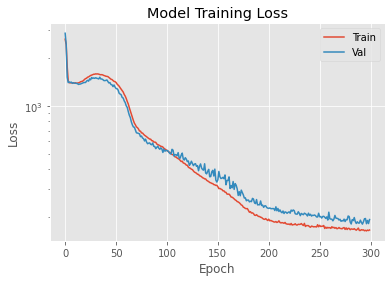

In [17]:
plot_training_loss(epoch_train_loss, epoch_val_loss)

possibly a learning rate problem/something to do with the different scaling of percent and fvc

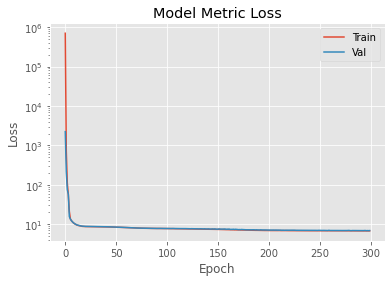

In [18]:
plot_training_loss(epoch_train_metric, epoch_val_metric,title='metric')

# Test Data

In [19]:
submission=pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv')

In [20]:
test_ids=test.Patient.unique()
test_dataset = OSIC(test_ids,test,good_file_dict,train=False)  
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False,num_workers=num_workers)
model.eval()
fvc_pred = []
sigma_pred = []
with torch.no_grad():
    for batch_idx, data in enumerate(test_dataloader):
        fvc,sigma = model(data['data'].float().to(device))
        fvc_pred.append(fvc)
        sigma_pred.append(sigma)
fvc_pred=torch.cat(fvc_pred, dim=0)
sigma_pred=torch.cat(sigma_pred, dim=0)
test['FVC']=fvc_pred.cpu().numpy()
test['Confidence']=sigma_pred.cpu().numpy()

In [21]:
test['Patient_Week']=test["Patient"] + '_' + test['Weeks'].apply(str)

In [22]:
submission=submission[['Patient_Week']].merge(test[['Patient_Week','FVC','Confidence']],on='Patient_Week')

In [23]:
submission.to_csv('submission.csv', index=False, float_format='%.1f')

# Post-Match Analysis

## Test Predictions

Text(0, 0.5, 'Confidence')

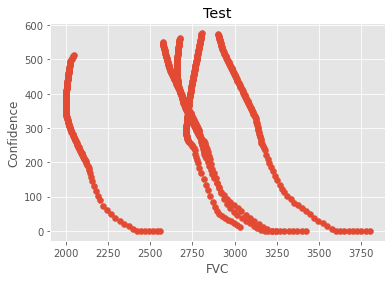

In [24]:
plt.scatter(submission['FVC'],submission['Confidence'])
plt.title('Test')
plt.xlabel('FVC')
plt.ylabel('Confidence')

## Train

train metric tensor(6.7753, dtype=torch.float64)


Text(0, 0.5, 'Confidence')

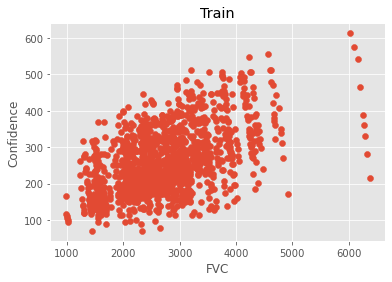

In [25]:
fvc_pred = []
sigma_pred = []
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,shuffle=False,num_workers=num_workers)
with torch.no_grad():
    for batch_idx, data in enumerate(train_dataloader):
        fvc,sigma = model(data['data'].float().to(device))
        fvc_pred.append(fvc)
        sigma_pred.append(sigma)
fvc_pred_train=torch.cat(fvc_pred, dim=0)
sigma_pred_train=torch.cat(sigma_pred, dim=0)

print('train metric', calc_metric_loss(fvc_pred_train,sigma_pred_train,train_dataset.fvc).mean())

plt.scatter(fvc_pred_train.cpu().numpy(),sigma_pred_train.cpu().numpy())
plt.title('Train')
plt.xlabel('FVC')
plt.ylabel('Confidence')


Text(0, 0.5, 'Predicted FVC')

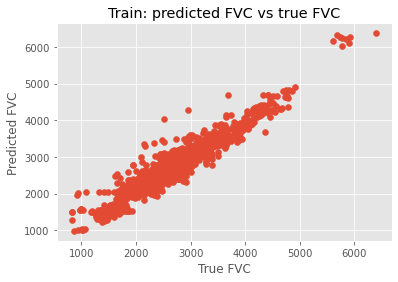

In [26]:
plt.scatter(train_dataset.fvc,fvc_pred_train)
plt.title('Train: predicted FVC vs true FVC')
plt.xlabel('True FVC')
plt.ylabel('Predicted FVC')

## Val

val metric 6.89795402393021


Text(0, 0.5, 'Confidence')

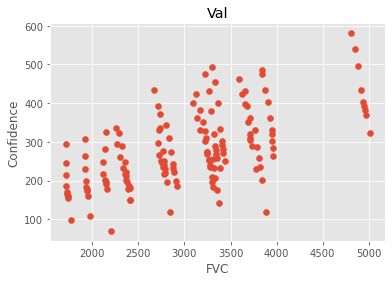

In [27]:
fvc_pred = []
sigma_pred = []
val_dataloader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False,num_workers=num_workers)
with torch.no_grad():
    for batch_idx, data in enumerate(val_dataloader):
        fvc,sigma = model(data['data'].float().to(device))
        fvc_pred.append(fvc)
        sigma_pred.append(sigma)
fvc_pred_val=torch.cat(fvc_pred, dim=0)
sigma_pred_val=torch.cat(sigma_pred, dim=0)

print('val metric', calc_metric_loss(fvc_pred_val.cpu().numpy(),sigma_pred_val.cpu().numpy(),val_dataset.fvc).mean())

plt.scatter(fvc_pred_val.cpu().numpy(),sigma_pred_val.cpu().numpy())
plt.title('Val')
plt.xlabel('FVC')
plt.ylabel('Confidence')

Text(0, 0.5, 'Predicted FVC')

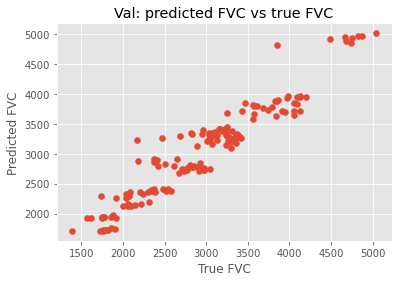

In [28]:
plt.scatter(val_dataset.fvc,fvc_pred_val)
plt.title('Val: predicted FVC vs true FVC')
plt.xlabel('True FVC')
plt.ylabel('Predicted FVC')

## All

Text(0.5, 1.0, 'Histogram of FVC predictions')

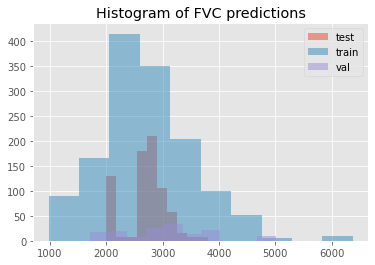

In [29]:
plt.hist(submission['FVC'], alpha=0.5,label='test')
plt.hist(fvc_pred_train.cpu().numpy(), alpha=0.5,label='train')
plt.hist(fvc_pred_val.cpu().numpy(), alpha=0.5,label='val')
plt.legend()
plt.title('Histogram of FVC predictions')

Text(0.5, 1.0, 'Histogram of Confidence predictions')

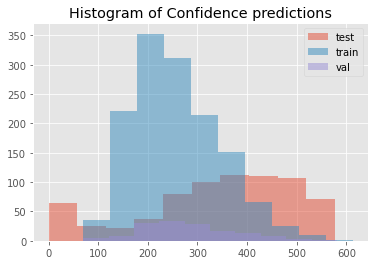

In [30]:
plt.hist(submission['Confidence'], alpha=0.5,label='test')
plt.hist(sigma_pred_train.cpu().numpy(), alpha=0.5,label='train')
plt.hist(sigma_pred_val.cpu().numpy(), alpha=0.5,label='val')
plt.legend()
plt.title('Histogram of Confidence predictions')